In [3]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

df = pd.read_csv('../data/metabric_example.tab', sep='\t')

# Calculate the median of the FLT3 column
median_flt3 = df['FLT3'].median()

# Create two groups: below and above median
flt3_low = df['FLT3'] <= median_flt3
flt3_high = df['FLT3'] > median_flt3



# fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))

# kmf = KaplanMeierFitter()
# kmf_low = kmf.fit(df['time'][flt3_low], df['event'][flt3_low], label='Low expression of FLT3')
# kmf_low.plot_survival_function(ax=ax[1])

# kmf_high = kmf.fit(df['time'][flt3_high], df['event'][flt3_high], label='High expression of FLT3')
# kmf_high.plot_survival_function(ax=ax[1], c='red')

# ax[0].set_ylabel("Survival probability")
# ax[0].set_xlabel("Time (months)")
# ax[1].set_xlabel("Time (months)")

# fig.tight_layout()

# plt.savefig('../figures/figure1_biomarker_example.pdf', dpi=300)


/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_46351/2668815670.py:90: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, 0])
/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_46351/2668815670.py:96: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, 1])


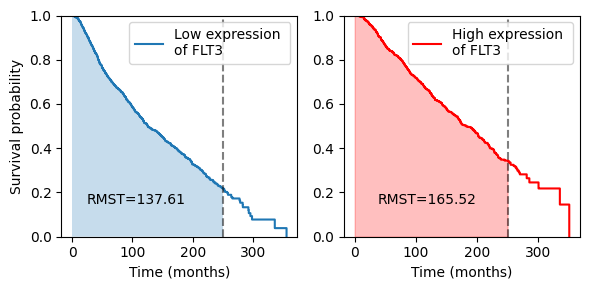

In [23]:
import numpy as np

def rmst_plot(model, model2=None, t=np.inf, ax=None, text_position=None, **plot_kwargs):
    """this part of the code is taken from lifelines.plotting to adjust colors and add aditional artifacts and text"""

    from lifelines.utils import restricted_mean_survival_time
    from matplotlib import pyplot as plt


    if ax is None:
        ax = plt.gca()

    rmst = restricted_mean_survival_time(model, t=t)
    c = plot_kwargs.pop("c", None)
    model.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)

    if text_position is None:
        text_position = (np.percentile(model.timeline, 10), 0.15)

    if model2 is not None:
        # c2 = ax._get_lines.get_next_color()
        c = 'red'
        rmst2 = restricted_mean_survival_time(model2, t=t)
        model2.plot_survival_function(ax=ax, color=c, ci_show=False, **plot_kwargs)
        timeline = np.unique(model.timeline.tolist() + model2.timeline.tolist() + [t])
        predict1 = model.predict(timeline).loc[:t]
        predict2 = model2.predict(timeline).loc[:t]
        # positive
        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 > predict2,
            step="post",
            # facecolor="w",
            # hatch="|",
             color="grey", alpha=0.25,
            edgecolor="grey",
        )

        # negative
        ax.fill_between(
            timeline[timeline <= t],
            predict1,
            predict2,
            where=predict1 < predict2,
            step="post",
            # hatch="-",
            # facecolor="w",
            color="grey", alpha=0.25,
            edgecolor="grey",
        )
        # ax.text(
        #     text_position[0], text_position[1], "RMST(%s) -\n   RMST(%s)=%.2f" % (model._label, model2._label, abs(round(rmst,2) - round(rmst2, 2)))
        # )  # dynamically pick this.
    else:
        rmst = restricted_mean_survival_time(model, t=t)
        sf_exp_at_limit = model.predict(np.append(model.timeline, t)).sort_index().loc[:t]
        ax.fill_between(sf_exp_at_limit.index, sf_exp_at_limit.values, step="post", color=c, alpha=0.25)
        ax.text(text_position[0], text_position[1], "RMST=%.2f" % rmst)  # dynamically pick this.

    ax.axvline(t, ls="--", color="k", alpha=0.5)
    ax.set_ylim(0, 1)
    return ax


from lifelines.utils import restricted_mean_survival_time
from lifelines.datasets import load_waltons
from lifelines import KaplanMeierFitter

time = 250

kmf = KaplanMeierFitter()
kmf_low = kmf.fit(df['time'][flt3_low], df['event'][flt3_low], label='Low expression \nof FLT3')
rmst_low = restricted_mean_survival_time(kmf_low, t=time)

kmf = KaplanMeierFitter()
kmf_high = kmf.fit(df['time'][flt3_high], df['event'][flt3_high], label='High expression \nof FLT3')
rmst_high = restricted_mean_survival_time(kmf_high, t=time)

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

gs = gridspec.GridSpec(1, 2)


ax = plt.subplot(gs[0, 0])
rmst_plot(kmf_low, t=time, ax=ax)
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5)
plt.ylabel("Survival probability")
plt.xlabel("Time (months)")

ax = plt.subplot(gs[0, 1])
r = rmst_plot(kmf_high, t=time, ax=ax, c='red')
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5)
# plt.ylabel("Survival probability")
plt.xlabel("Time (months)")

# ax = plt.subplot(gs[1, :])
# rmst_plot(kmf_low, model2=kmf_high, t=time, ax=ax)
# plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1)
# plt.ylabel("Survival probability")
# plt.xlabel("Time (months)")

fig.tight_layout()
plt.savefig('../figures/figure2_rmst.pdf', dpi=300)



# fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(7, 7))

# gs = gridspec.GridSpec(2, 2)


# ax = plt.subplot(gs[0, 0])
# rmst_plot(kmf_low, t=time, ax=ax)
# plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1)
# plt.ylabel("Survival probability")
# plt.xlabel("Time (months)")

# ax = plt.subplot(gs[0, 1])
# r = rmst_plot(kmf_high, t=time, ax=ax, c='red')
# plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1)
# plt.ylabel("Survival probability")
# plt.xlabel("Time (months)")

# ax = plt.subplot(gs[1, :])
# rmst_plot(kmf_low, model2=kmf_high, t=time, ax=ax)
# plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1)
# plt.ylabel("Survival probability")
# plt.xlabel("Time (months)")



# fig.tight_layout()

# plt.savefig('../figures/figure2_rmst_diff.pdf', dpi=300)

/var/folders/rv/jt6y7k_x4gs3_r7tcpxzmp9m0000gn/T/ipykernel_46351/1924473670.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs[0, :])


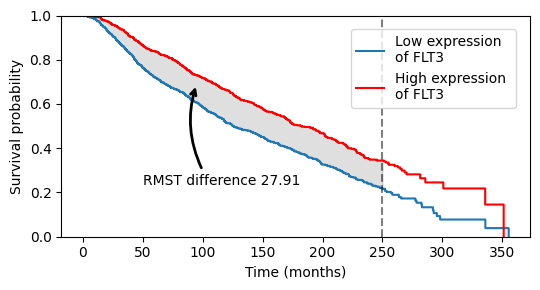

In [27]:
from matplotlib.patches import FancyArrowPatch

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(5.5, 3)) # figsize=(5, 3.2)

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, :])
rmst_plot(kmf_low, model2=kmf_high, t=time, ax=ax)


arrow = FancyArrowPatch((100, 0.3), (95, 0.69), connectionstyle="arc3,rad=-.2", mutation_scale = 10, arrowstyle='->', lw=2, zorder=10)
ax.add_patch(arrow)


ax.text( 50, 0.25, f"RMST difference {abs(round(rmst_high - rmst_low, 2))}", fontsize=10, ha='left', va='center', zorder=10)

plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=1)
plt.ylabel("Survival probability")
plt.xlabel("Time (months)")
fig.tight_layout()

plt.savefig('../figures/figure3_rmst_diff_small.pdf', dpi=300)